In [1]:
import pandas as pd

train_data = pd.read_csv("data/train.csv")

In [2]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [6]:
stops = set(stopwords.words('english'))

In [7]:
def preprocess_questions(quest1, quest2, stemmer):
    q1_tokens = word_tokenize(quest1.lower())
    q2_tokens = word_tokenize(quest2.lower())
    q1_tokens = [word for word in q1_tokens if word not in stops]
    q2_tokens = [word for word in q2_tokens if word not in stops]
    q1_snowball = [stemmer.stem(token) for token in q1_tokens]
    q2_snowball = [stemmer.stem(token) for token in q2_tokens]
    return q1_snowball, q2_snowball

In [8]:
def perc_matching_words(q1_snowball, q2_snowball):
    common = set(q1_snowball).intersection( set(q2_snowball) )
    unique = set(q1_snowball).union( set(q2_snowball) )
    print(common,unique)
    common_percent = len(common)/(len(unique))
    return round(common_percent,2)

In [9]:
def get_len_questions(q1_snowball, q2_snowball):
    return len(q1_snowball), len(q2_snowball)

In [10]:
def get_num_stop_words(quest1, quest2):
    q1_tokens = word_tokenize(quest1.lower())
    q2_tokens = word_tokenize(quest2.lower())
    q1_tokens = [word for word in q1_tokens if word in stops]
    q2_tokens = [word for word in q2_tokens if word in stops] 
    return len(q1_tokens),len(q2_tokens)

In [11]:
test_data = pd.read_csv("./data/test.csv")
embeddings = "./GoogleNews-vectors-negative300.bin.gz"

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Cleaning and building the embedding matrix for the word corpora

In [12]:
from time import time
import numpy as np
from gensim.models import KeyedVectors
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [13]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(embeddings, binary=True)

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_data, test_data]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:70: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [14]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 8, 11]","[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10]",0
1,1,3,4,"[1, 2, 3, 12, 13, 14, 15, 16, 15, 17, 18]","[1, 19, 20, 21, 3, 22, 23, 24, 3, 13, 14, 15, ...",0
2,2,5,6,"[26, 27, 16, 28, 3, 29, 30, 31, 32, 33, 34, 35]","[26, 27, 31, 29, 36, 37, 5, 38, 39, 40]",0
3,3,7,8,"[41, 42, 16, 43, 44, 45, 26, 27, 16, 46, 47]","[48, 3, 49, 50, 51, 52, 53, 54, 51, 2, 55, 5, ...",0
4,4,9,10,"[56, 57, 58, 8, 59, 60, 61, 62, 63, 64, 65, 66]","[56, 67, 19, 68, 8, 62, 59]",0


In [15]:
test_data.head()

,test_id,question1,question2
0,0,"[26, 76, 3, 1663, 1237, 5472, 745, 149, 175, 4...","[41, 330, 3863, 331, 1580, 12991, 212, 1580, 6..."
1,1,"[84, 16, 401, 942, 11093, 225, 833, 54, 26, 21...","[26, 214, 534, 76, 942, 11093, 1864]"
2,2,"[1, 1220, 2, 3, 195, 250, 1096, 251, 91, 817, ...","[1, 99, 1096, 251, 817]"
3,3,"[56, 818, 212, 31956]","[1, 388, 11099]"
4,4,"[26, 86002, 1221, 1204]","[26, 290, 27, 16, 1221, 1204]"


In [16]:
max_seq_length = max(train_data.question1.map(lambda x: len(x)).max(),
                     train_data.question2.map(lambda x: len(x)).max(),
                     test_data.question1.map(lambda x: len(x)).max(),
                     test_data.question2.map(lambda x: len(x)).max())

In [17]:
train_data['question1_vec'] = None
train_data['question2_vec'] = None
test_data['question1_vec'] = None
test_data['question2_vec'] = None

In [21]:
for dataset in [train_data, test_data]:
    for index, row in dataset.iterrows():
        # Iterate through the text of both questions of the row
        for question in questions_cols:
            q_vec = np.zeros(embedding_dim)
            for indx in row[question]:
                q_vec = np.add(q_vec, embeddings[indx])
            if(len(row[question]) > 0):
                q_vec = q_vec/len(row[question])
            dataset.set_value(index, question + '_vec', q_vec)

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [25]:
train_data.drop(columns = ['question1_vec','question2_vec'], inplace=True)

In [26]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 8, 11]","[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10]",0
1,1,3,4,"[1, 2, 3, 12, 13, 14, 15, 16, 15, 17, 18]","[1, 19, 20, 21, 3, 22, 23, 24, 3, 13, 14, 15, ...",0
2,2,5,6,"[26, 27, 16, 28, 3, 29, 30, 31, 32, 33, 34, 35]","[26, 27, 31, 29, 36, 37, 5, 38, 39, 40]",0
3,3,7,8,"[41, 42, 16, 43, 44, 45, 26, 27, 16, 46, 47]","[48, 3, 49, 50, 51, 52, 53, 54, 51, 2, 55, 5, ...",0
4,4,9,10,"[56, 57, 58, 8, 59, 60, 61, 62, 63, 64, 65, 66]","[56, 67, 19, 68, 8, 62, 59]",0


In [27]:
test_data.drop(columns = ['question1_vec','question2_vec'], inplace=True)
test_data.head()

,test_id,question1,question2
0,0,"[26, 76, 3, 1663, 1237, 5472, 745, 149, 175, 4...","[41, 330, 3863, 331, 1580, 12991, 212, 1580, 6..."
1,1,"[84, 16, 401, 942, 11093, 225, 833, 54, 26, 21...","[26, 214, 534, 76, 942, 11093, 1864]"
2,2,"[1, 1220, 2, 3, 195, 250, 1096, 251, 91, 817, ...","[1, 99, 1096, 251, 817]"
3,3,"[56, 818, 212, 31956]","[1, 388, 11099]"
4,4,"[26, 86002, 1221, 1204]","[26, 290, 27, 16, 1221, 1204]"


In [42]:
from sklearn.model_selection import train_test_split

X = train_data[questions_cols]
Y = train_data['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_data.question1, 'right': test_data.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

## Building the model

We will be using a **Siamese LSTM** network where the two question sequences share the common LSTM layer and go in as an input to this layer.

We have two embedded matrices that represent a candidate of two similar questions. Then we feed them into the LSTM (practically, there is only one) and the final state of the LSTM for each question is a 50-dimensional vector. It is trained to capture semantic meaning of the question.

By now we have the two vectors that hold the semantic meaning of each question. We put them through the **Manhattan Similarity function** to determine the probability of them being similar and getting the predicted probability.

In [43]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 323432 samples, validate on 80858 samples
Epoch 1/25
323432/323432 [==============================] - 3200s 10ms/step - loss: 0.1762 - acc: 0.7435 - val_loss: 0.1631 - val_acc: 0.7651
Epoch 2/25
323432/323432 [==============================] - 3198s 10ms/step - loss: 0.1558 - acc: 0.7800 - val_loss: 0.1541 - val_acc: 0.7849
Epoch 3/25
323432/323432 [==============================] - 3193s 10ms/step - loss: 0.1482 - acc: 0.7941 - val_loss: 0.1484 - val_acc: 0.7939
Epoch 4/25
323432/323432 [==============================] - 3196s 10ms/step - loss: 0.1435 - acc: 0.8011 - val_loss: 0.1474 - val_acc: 0.7894
Epoch 5/25
323432/323432 [==============================] - 3191s 10ms/step - loss: 0.1402 - acc: 0.8065 - val_loss: 0.1430 - val_acc: 0.8008
Epoch 6/25
323432/323432 [==============================] - 3199s 10ms/step - loss: 0.1375 - acc: 0.8096 - val_loss: 0.1413 - val_acc: 0.8017
Epoch 7/25
323432/323432 [==============================] - 3190s 10ms/step - loss: 0.1353 - acc:

In [44]:
# serialize model to JSON
model_json = malstm.to_json()
with open("malstm.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
malstm.save_weights("malstm.h5")
print("Saved model to disk")

Saved model to disk


### Log Loss On the training data

In [45]:
Y_train_pred = malstm.predict([X_train['left'], X_train['right']])

In [46]:
Y_valid_pred = malstm.predict([X_validation['left'], X_validation['right']])

In [52]:
Y_t_pred = Y_train_pred.flatten()
Y_t_pred.shape

(323432,)

In [57]:
Y_t_pred = Y_t_pred.astype(np.float64)

In [58]:
Y_t_pred[0:5]

array([1.91363990e-01, 8.66466701e-01, 3.56678754e-01, 1.93653479e-01,
       2.39195768e-04])

In [59]:
Y_train[0:5]

array([1, 1, 0, 0, 0])

In [60]:
from sklearn.metrics import log_loss

### Loss on training data

In [62]:
print("Loss on training data", log_loss(Y_train,Y_t_pred))

Loss on training data 0.39895182954222513


### Loss on validation data

In [63]:
Y_v_pred = Y_valid_pred.flatten()
Y_v_pred = Y_v_pred.astype(np.float64)

In [64]:
print("Loss on validation data", log_loss(Y_validation,Y_v_pred))

Loss on validation data 0.43374361027617436


### Let's calculate the probabilities for the test dataset

In [ ]:
# Zero padding
for side in ['left', 'right']:
    X_test[side] = pad_sequences(X_test[side], maxlen=max_seq_length)

In [70]:
# Make sure everything is ok
assert X_test['left'].shape == X_test['right'].shape

In [71]:
Y_test_pred = malstm.predict([X_test['left'], X_test['right']], batch_size=200)

In [72]:
Y_test_pred.shape

(3563475, 1)

Let's flatten the output and convert it into floating point 64 bit number.

In [73]:
Y_tst_pred = Y_test_pred.flatten()
Y_tst_pred = Y_tst_pred.astype(np.float64)

In [74]:
test_data.shape

(3563475, 3)

Let's look into the **auc-roc curve** and find the best probability threshold.

Area under the ROC curve : 0.885984


/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


[]

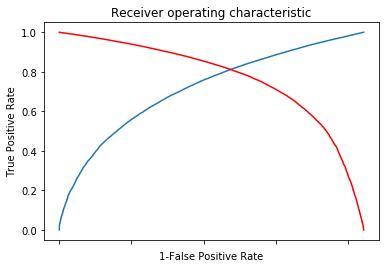

In [78]:
from sklearn.metrics import roc_curve, auc
import pylab as pl

fpr, tpr, thresholds =roc_curve(Y_validation, Y_v_pred)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = pl.subplots()
pl.plot(roc['tpr'])
pl.plot(roc['1-fpr'], color = 'red')
pl.xlabel('1-False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [81]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [82]:
Find_Optimal_Cutoff(Y_validation, Y_v_pred)

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[0.3785533607006073]

In [83]:
Y_test_out = [1 if pred > 0.37855336 else 0 for pred in Y_tst_pred]

In [92]:
test_data['is_duplicate'] = Y_tst_pred

In [100]:
test_data.head()

,test_id,question1,question2,is_duplicate
0,0,"[26, 76, 3, 1663, 1237, 5472, 745, 149, 175, 4...","[41, 330, 3863, 331, 1580, 12991, 212, 1580, 6...",0.023779
1,1,"[84, 16, 401, 942, 11093, 225, 833, 54, 26, 21...","[26, 214, 534, 76, 942, 11093, 1864]",0.330959
2,2,"[1, 1220, 2, 3, 195, 250, 1096, 251, 91, 817, ...","[1, 99, 1096, 251, 817]",0.552646
3,3,"[56, 818, 212, 31956]","[1, 388, 11099]",0.002205
4,4,"[26, 86002, 1221, 1204]","[26, 290, 27, 16, 1221, 1204]",0.073363


In [98]:
test_data_submit = test_data.iloc[0:2345796,:]

In [99]:
test_data_submit.shape

(2345796, 4)

Let's export this to a csv in submission format

In [103]:
test_data_submit[['test_id','is_duplicate']].to_csv("malstm_aryan.csv",index=False)

In [104]:
len(test_data_submit)

2345796

In [89]:
len(test_data['test_id'].unique())

2607940

Visualize the model

In [106]:
malstm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 213)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 213)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 213, 300)     36396000    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)           70200       embedding_1[0][0]                
          